<a href="https://colab.research.google.com/github/robinvvinod/spaceapps/blob/master/charts/county_correlations.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [220]:
#github clone
#put this on top of any analysis to automatically download latest repo into 'spaceapps/' directory. You must then put 'spaceapps/' into directory structure eg 'spaceapps/county_fips_codes.csv'
!rm -rf spaceapps
!git clone https://github.com/robinvvinod/spaceapps.git


Cloning into 'spaceapps'...
remote: Enumerating objects: 86, done.
remote: Counting objects: 100% (86/86), done.
remote: Compressing objects: 100% (66/66), done.
remote: Total 273 (delta 38), reused 48 (delta 18), pack-reused 187
Receiving objects: 100% (273/273), 14.86 MiB | 14.51 MiB/s, done.
Resolving deltas: 100% (124/124), done.


In [221]:
#init
import pandas as pd
import numpy as np
import sys
import statsmodels.formula.api as sm
from scipy import stats
import matplotlib.pyplot as plt

#loading county mobility so it's 14 day MA timeseries indexed by fips
mob_df = pd.read_csv('spaceapps/applemobilitydata/applemobilitycleaned_county.csv');
mob_df = mob_df.drop(['Unnamed: 0'], axis=1)
fips2region_df = mob_df.iloc[:,:3]
mob_df = mob_df.drop(['region','sub-region'], axis=1)
mob_ma_df=mob_df

#apply 14 day SMA to all counties
for fips_index in range(0,mob_ma_df.index.size):

  mob_ma_df.iloc[fips_index,1:] = mob_ma_df.iloc[fips_index,1:].rolling(window=14).mean()

#remove first 13 days which are NA due to 14 day moving average
mob_ma_df = mob_ma_df.dropna(axis=1,how='all')
mob_ma_df

,fips,2020-01-26,2020-01-27,2020-01-28,2020-01-29,2020-01-30,2020-01-31,2020-02-01,2020-02-02,2020-02-03,2020-02-04,2020-02-05,2020-02-06,2020-02-07,2020-02-08,2020-02-09,2020-02-10,2020-02-11,2020-02-12,2020-02-13,2020-02-14,2020-02-15,2020-02-16,2020-02-17,2020-02-18,2020-02-19,2020-02-20,2020-02-21,2020-02-22,2020-02-23,2020-02-24,2020-02-25,2020-02-26,2020-02-27,2020-02-28,2020-02-29,2020-03-01,2020-03-02,2020-03-03,2020-03-04,...,2020-04-16,2020-04-17,2020-04-18,2020-04-19,2020-04-20,2020-04-21,2020-04-22,2020-04-23,2020-04-24,2020-04-25,2020-04-26,2020-04-27,2020-04-28,2020-04-29,2020-04-30,2020-05-01,2020-05-02,2020-05-03,2020-05-04,2020-05-05,2020-05-06,2020-05-07,2020-05-08,2020-05-09,2020-05-10,2020-05-13,2020-05-14,2020-05-15,2020-05-16,2020-05-17,2020-05-18,2020-05-19,2020-05-20,2020-05-21,2020-05-22,2020-05-23,2020-05-24,2020-05-25,2020-05-26,2020-05-27
0,45001.0,115.232143,115.958571,116.970714,117.286429,117.541429,117.345714,119.329286,120.872143,120.681429,120.596429,121.432857,120.250714,120.741429,120.085000,120.866429,121.262143,120.390000,120.114286,120.645714,122.148571,122.715000,122.104286,123.026429,121.774286,121.519286,122.671429,124.039286,126.498571,126.583571,126.287857,126.703571,128.482143,128.572143,128.311429,127.940714,127.770000,127.684286,128.110000,128.210000,...,96.785000,98.177143,100.060714,99.510000,99.785000,101.142143,102.815714,102.730714,103.592143,105.015000,109.452857,110.395000,111.557143,112.273571,113.425000,114.897857,116.585714,120.022143,121.730714,123.433571,124.640714,127.650714,129.759286,131.657857,131.462143,134.166429,136.976429,139.595714,143.783571,144.855714,143.192857,144.600000,145.150714,145.922143,148.331429,152.303571,151.392143,150.235000,153.801429,154.617857
1,22001.0,122.414286,123.332857,122.915000,122.685000,121.794286,121.828571,122.041429,121.480714,121.175714,121.017857,119.799286,118.150714,118.510714,118.309286,119.284286,119.008571,119.702857,119.685000,121.093571,122.687857,123.127143,124.408571,124.486429,125.083571,127.035000,128.458571,132.002143,134.536429,141.838571,145.072143,145.570000,147.942143,148.289286,149.227143,150.197857,151.079286,151.955714,152.554286,151.678571,...,75.085000,77.027143,78.148571,78.550714,79.847143,81.734286,82.625000,83.582143,86.479286,88.917857,91.119286,92.992143,94.668571,95.939286,97.547143,99.755714,102.587857,104.569286,106.700000,108.074286,109.877143,111.545714,113.234286,114.910714,116.372857,118.140000,120.077143,123.151429,124.598571,123.457857,125.537857,147.517857,149.508571,152.492143,157.621429,160.875714,160.127857,160.071429,164.013571,166.948571
2,51001.0,106.111429,105.976429,105.528571,104.467143,104.302143,101.969286,101.965000,100.494286,99.078571,98.888571,99.100000,98.850714,98.123571,99.484286,108.791429,109.171429,109.264286,110.477857,110.977143,115.905000,123.262857,127.400714,131.035000,132.847857,133.477857,134.285000,135.307857,136.077143,128.520000,128.879286,129.125000,129.378571,129.661429,126.795714,121.424286,120.308571,117.955000,117.042143,117.270000,...,62.553571,63.318571,64.240000,65.630714,66.285714,67.963571,68.897143,69.865000,71.192143,72.307857,73.761429,74.957857,76.864286,76.973571,77.408571,78.795000,80.122143,82.272857,85.104286,85.860714,86.470000,87.450714,89.656429,91.634286,92.509286,95.311429,96.532857,101.102143,106.859286,109.487857,111.690000,113.723571,114.679286,119.087857,125.393571,133.724286,138.665000,143.944286,150.216429,152.473571
3,16001.0,103.109286,103.014286,103.207857,103.333571,103.330000,103.581429,104.125714,103.770000,103.737857,103.783571,103.812143,103.951429,104.901429,105.567143,106.240714,106.774286,107.385000,107.955000,109.035000,110.055000,110.017143,110.887143,111.568571,112.111429,112.417857,113.240000,113.945000,115.137857,115.517143,115.840000,116.037143,115.857857,115.935000,116.610714,117.947143,118.372857,118.405714,118.513571,118.622143,...,67.740714,69.115000,70.502143,71.607143,72.962857,74.010714,74.871429,75.707857,76

In [0]:
#loading county cases so it's timeseries indexed by fips
cases_df = pd.read_csv('spaceapps/covidstats/confirmed_cases_county_cumulative.csv')
cases_df = cases_df.drop(['Unnamed: 0'], axis=1)

#remove first 3 days to match county mobility but include fips for future lookup
cases_df = cases_df.iloc[:,[0, *range(5,cases_df.iloc[1,:].size)]]

#remove 05-12&13&28 to match county mobility
cases_df = cases_df.drop(columns=['2020-05-12','2020-05-13','2020-05-28'])

#sanity check to make sure they have same number of days 
#cases_df.shape, mob_ma_df.shape


In [0]:
#predefine counties_correlations_df dataframe to store regression results
mob_num_counties = mob_ma_df.shape[0]
d = {'r': np.full([mob_num_counties], np.nan), 'p': np.full([mob_num_counties], np.nan), 'se': np.full([mob_num_counties], np.nan), 'slope': np.full([mob_num_counties], np.nan), 'intercept': np.full([mob_num_counties], np.nan)}
counties_correlations_df = pd.DataFrame(data=d,index=mob_ma_df.index)

#go through all fips codes in mobility data
for fips_index in range(0,mob_ma_df.index.size):
  axx = mob_ma_df.iloc[fips_index,1:]
  axy = cases_df.loc[cases_df['fips']==mob_ma_df.iloc[fips_index,0],cases_df.columns.difference(['fips'])]

  #don't bother regressing if all cases are 0s
  if all((axy==0).all()):
    slope = intercept = r_value = p_value = std_err = np.nan
  else:
    #linear regression
    slope, intercept, r_value, p_value, std_err = stats.linregress(axx,axy)

  counties_correlations_df.iloc[fips_index,0] = r_value
  counties_correlations_df.iloc[fips_index,1] = p_value
  counties_correlations_df.iloc[fips_index,2] = std_err
  counties_correlations_df.iloc[fips_index,3] = slope
  counties_correlations_df.iloc[fips_index,4] = intercept

#merge with regional info for human interpretation
counties_correlations_df=fips2region_df.join(counties_correlations_df)

In [224]:
#looking at all correlations in New York state
counties_correlations_df.loc[counties_correlations_df['sub-region'] == 'New York']

,fips,region,sub-region,r,p,se,slope,intercept
13,36001.0,Albany County,New York,-0.205972,2.341899e-02,2.251827,-5.170461,1068.718849
145,36005.0,Bronx County,New York,NaN,NaN,NaN,NaN,NaN
149,36007.0,Broome County,New York,-0.297884,9.053965e-04,0.592129,-2.015650,336.673612
212,36009.0,Cattaraugus County,New York,-0.296965,9.408097e-04,0.089567,-0.303861,52.100760
213,36011.0,Cayuga County,New York,0.122620,1.802857e-01,0.131582,0.177345,3.182824
229,20019.0,Chautauqua County,New York,-0.429250,8.981472e-07,0.006926,-0.035907,5.196329
234,36015.0,Chemung County,New York,-0.184872,4.235478e-02,0.285309,-0.585480,99.309514
235,36017.0,Chenango County,New York,-0.010807,9.063514e-01,0.212057,-0.025000,43.234553
300,36023.0,Cortland County,New York,-0.646130,1.212984e-15,0.025569,-0.236135,40.459334
382,36027.0,Dutchess County,New York,-0.465519,7.441377e-08,5.160327,-29.609140,3850.012801


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:10: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  # Remove the CWD from sys.path while we load stuff.


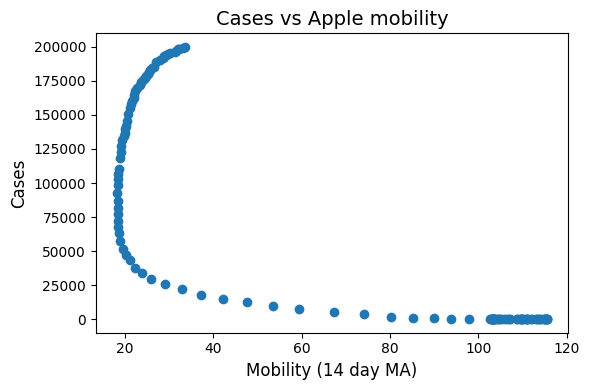

In [225]:
#function to plot graph for desired fips code
def Graph(fips):
  timeseries=mob_ma_df.loc[mob_ma_df['fips'] == fips,:]
  axx = timeseries.loc[:,timeseries.columns.difference(['fips'])]
  timeseries=cases_df.loc[cases_df['fips'] == fips,:]
  axy = timeseries.loc[:,timeseries.columns.difference(['fips'])]

  fig1 = plt.figure(num=None, figsize=(6, 4), dpi=100, facecolor='w', edgecolor='k')
  plt.scatter(axx,axy)
  ax = plt.axes()
  plt.xlabel(r'Mobility (14 day MA)', fontsize = 12.0)
  plt.ylabel(r'Cases', fontsize = 12.0)
  plt.title(r'Cases vs Apple mobility', fontsize = 14.0)
  fig1.tight_layout()
  plt.show()

#example plot of New York County (fips=36061) cases vs mobility 
Graph(36061.0)

